In [1]:
from src import LangevinFunctions
from src import StatsFunctions
from src import MSDFunctions
from src import PlottingFunctions
SF_F = StatsFunctions.Statistics_Functions()
LF_F = LangevinFunctions.LF()
MSD = MSDFunctions.MSD()
plots = PlottingFunctions.Plotter()
import numpy as np
import matplotlib.pyplot as plt

First, we will generate some single particle tracking data. We can use the LangevinFunctions module to do this.

In [2]:
"""     BrownianTrans_Realistic generates displacements (Delta)
        from equations 2--5 of Michalet, X.; Berglund, A. J.
        Phys. Rev. E 2012, 85 (6), 061916.
        https://doi.org/10.1103/PhysRevE.85.061916.
        This function assumes a realistic brownian motion tracked
        using a camera.

        Args:
            DT (float): translational diffusion coefficient
            N (int): number of steps to simulate
            n_d (int): mumber of dimensions of diffusion
            deltaT (flaot): time step between data points
            tE (float): camera exposure duration (can be same as deltaT)
            sigma0 (float): static localisation error
            s0 (float): standard deviation of the PSF
            R (float): motion blur coefficient (see Equation 5 of paper)

        Returns:
            coordinates (np.ndarray): coordinates over time
"""

N = 100; # number of data points in our track
DT = 1. # diffusion coefficient
dT = 100e-3 # timestep
sigma0 = 0.05 # 50 nm localisation precision
s0 = 0.25 # 250 nm psf
n_d = 3 # 3-dimensional diffusion

coordinates = LF_F.BrownianTrans_Realistic(DT=DT, N=N, deltaT=dT, n_d=n_d, tE=dT, sigma0=sigma0, s0=s0, R=1./6)

Then, we analyse it using our mean squared displacement function, using the OLSF of Michalet.

In [3]:
"""
        Compute diffusion coefficient estimate, and estimate of the
        dynamic localisation error, using the MLE approach.
    
        Args:
            coordinates (numpy.ndarray): Input trajectory.
            dT (float): Time interval.
            R (float): Motion blur coefficient.
            n_d (int): number of dimensions. If above 1, coordinates second
                        dimension should be same shape as this number
            maxiter (int): Maximum number of iterations. Defaults to 100.
    
        Returns:
            D (float): estimate of D value.
            sigma (float): estimate of dynamic localisation std.
"""

D, sigma = MSD.DSigma2_OLSF(coordinates, dT, R=1./6, n_d=n_d)
print("Diffusion coefficient estimate is ", D)
print("Estimate of dynamic localisation variance is ", sigma)

Diffusion coefficient estimate is  0.8924444683324612
Estimate of dynamic localisation variance is  -0.011299150196106167


This may be out! We can quickly simulate 1,000 different actualisations of our coordinate to confirm that on average our OLSF does well. Though NB, the MLE is more robust (see the papers).

In [4]:
D_estimates = np.zeros(1000)
sigma_estimates = np.zeros(1000)

for i in np.arange(1000):
    coordinates = LF_F.BrownianTrans_Realistic(DT=DT, N=N, deltaT=dT, n_d=n_d, tE=dT, sigma0=sigma0, s0=s0, R=1./6)
    D_estimates[i], sigma_estimates[i] = MSD.DSigma2_OLSF(coordinates, dT, R=1./6, n_d=n_d)

Then let's plot these in a histogram to lay our fears to rest that our estimator is "off".

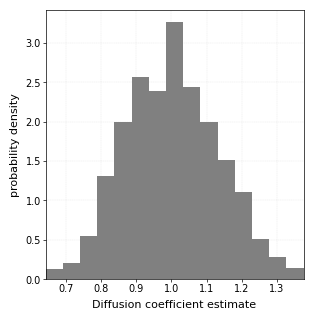

In [5]:
fig, ax = plots.one_column_plot()

D_estimates = D_estimates[~np.isnan(D_estimates)]
ax = plots.histogram_plot(axs=ax, data=D_estimates, bins=SF_F.bincalculator(D_estimates), xaxislabel='Diffusion coefficient estimate');

plt.show()

We can also compute (crudely) errors on our D and $\sigma$ parameters using bootstrapping. This is done by using the DSigma_MLE_BootStrap function.

In [6]:
"""
        Compute diffusion coefficient estimate, and estimate of the
        dynamic localisation error, using the MLE approach.
    
        Args:
            coordinates (np.ndarray): coordinates over time.
            dT (float): Time step.
            R (float): Motion blur coefficient.
            n_d (int): number of dimensions. If above 1, coordinates second
                        dimension should be same shape as this number
            maxiter (int): maximum number of optimisation iterations to make
            maxfun (int): maximum number of function evaluations to make
            n_samples (int): number of boostrapped samples. default 100.
    
        Returns:
            D_err (float): estimate of D value error
            sigma_err (float): estimate of dynamic localisation std error
"""

D_error, sigma_error = MSD.DSigma2_OLSF_BootStrap(coordinates, dT, R=1./6, n_d=n_d)
print("Diffusion coefficient estimate error is ", D_error)
print("Estimate of dynamic localisation std is ", sigma_error)

Diffusion coefficient estimate error is  0.11052736492557182
Estimate of dynamic localisation std is  0.00842033468478491


We can also read in data using pandas and analyse that, deducing the time step from our file, and then analyse the data.

In [7]:
import pandas as pd

data = pd.read_csv(r'Example_Tracking_Data/Example_Tracking_Data.csv', index_col=0)
dT = np.mean(np.diff(data.index))

D, sigma = MSD.DSigma2_OLSF(data.values, dT, R=1./6, n_d=data.shape[1])
print("Diffusion coefficient estimate is ", D)
print("Estimate of dynamic localisation std is ", sigma)

D_error, sigma_error = MSD.DSigma2_OLSF_BootStrap(data.values, dT, R=1./6, n_d=n_d)
print("Diffusion coefficient estimate error is ", D_error)
print("Estimate of dynamic localisation std is ", sigma_error)

Diffusion coefficient estimate is  1.0094163837259534e-12
Estimate of dynamic localisation std is  -1.5430915321540825e-14
Diffusion coefficient estimate error is  3.2243919697844473e-14
Estimate of dynamic localisation std is  2.422879893791278e-15
